## 🌊 Regresión lineal

#### Librerías y ajustes iniciales

In [1]:
import sys
sys.path.append("../../") # go to parent dir

In [2]:
from sklearn.linear_model import *
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
pd.options.display.max_columns = 50 # para mostrar todas las columnas

### 🔨 Construcción de modelos

In [28]:
# cargamos datos
X, y = datos_full()
# Eliminamos las columnas repetidas (visto en el notebook del analisis)
X = X.drop(columns=["Temperatura", 'wspd'])

#### Separación en train y test

In [29]:
# Para el modelo con todas las variables
X_train, X_test, y_train, y_test = sep_train_test()

#### Distribuciones de a variable respuesta en train y test

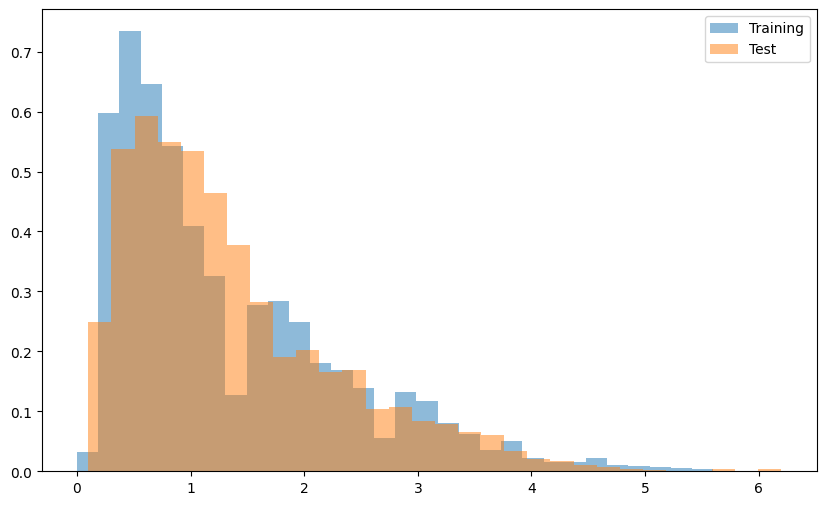

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(y_train, bins=30, alpha=0.5, label='Training', density=True)
ax.hist(y_test, bins=30, alpha=0.5, label='Test', density=True)
plt.legend()

Analizando las funciones de densidad de los dos conjuntos vemos que se parecen bastante, a excepción de las olas de altura alrededor de 0.5 metros, las cuáles parecen estar en mayor proporción en training que en el conjunto test.

#### Definimos funciones auxiliares para evitar repetir mucho codigo

In [24]:
def lineal_sin_reg(x_tr, x_te, y_tr, y_te, exp_name, exp_info="Modelo regresión lineal multivariable sin regularizar"):
    flo = MLFlow(exp_name)
    lr = LinearRegression()
    cv_metrics = cross_validate(lr, x_tr, y_tr, cv=cv_folds(), scoring="neg_root_mean_squared_error", return_train_score=True)
    lr.fit(x_tr, y_tr)
    
    # metricas TEST
    metricas = calcular_metricas(y_te, lr.predict(x_te))
    # metricas CV
    metricas["CV_TEST_RMSE"] = -1 * cv_metrics['test_score'].mean()
    metricas["CV_TRAIN_RMSE"] = -1 * cv_metrics['train_score'].mean()
    
    flo.persist_model_to_mlflow(x_tr, lr, {"random_state": RANDOM_SEED}, metricas, exp_name, exp_info)

In [25]:
def ridge(x_tr, x_te, y_tr, y_te, exp_name, exp_info="Modelo ridge"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "solver": ['svd', 'cholesky', 'lsqr'],
        "max_iter": [None, 100, 500, 1000],
    }
    flo = MLFlow(exp_name)

    rdgSearch = GridSearchCV(Ridge(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    rdgSearch.fit(x_tr, y_tr)

    flo.persist_model_to_mlflow(x_tr, rdgSearch.best_estimator_, rdgSearch.best_params_, calcular_metricas_search(rdgSearch, x_te, y_te), exp_name, exp_info)

    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 1)],
        "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        "max_iter": [None, 100, 500, 1000],
    }
    
    rdgRanSearch = RandomizedSearchCV(Ridge(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    rdgRanSearch.fit(x_tr, y_tr)

    flo.persist_model_to_mlflow(x_tr, rdgRanSearch.best_estimator_, rdgRanSearch.best_params_, calcular_metricas_search(rdgRanSearch, x_te, y_te), exp_name, exp_info)

    

In [26]:
def lasso(x_tr, x_te, y_tr, y_te, exp_name, exp_info="Modelo lasso"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "selection": ['cyclic', 'random'],
        "max_iter": [None, 100, 500, 1000, 2000],
    }
    flo = MLFlow(exp_name)

    lasSearch = GridSearchCV(Lasso(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    lasSearch.fit(x_tr, y_tr)
    
    flo.persist_model_to_mlflow(x_tr, lasSearch.best_estimator_, lasSearch.best_params_, calcular_metricas_search(lasSearch, x_te, y_te), exp_name, exp_info)
    
    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 1)],
        "selection": ['cyclic', 'random'],
        "max_iter": [None, 100, 500, 1000, 2000],
    }
    
    lasRanSearch = RandomizedSearchCV(Lasso(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    lasRanSearch.fit(x_tr, y_tr)

    flo.persist_model_to_mlflow(x_tr, lasRanSearch.best_estimator_, lasRanSearch.best_params_, calcular_metricas_search(lasRanSearch, x_te, y_te), exp_name, exp_info)


In [27]:
def elastic(x_tr, x_te, y_tr, y_te, exp_name, exp_info="Modelo elastic net"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 10)],
        "l1_ratio": [i/100 for i in range(0, 101, 10)],
        "max_iter": [None, 500],
    }
    flo = MLFlow(exp_name)

    elSearch = GridSearchCV(ElasticNet(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    elSearch.fit(x_tr, y_tr)
    
    flo.persist_model_to_mlflow(x_tr, elSearch.best_estimator_, elSearch.best_params_, calcular_metricas_search(elSearch, x_te, y_te), exp_name, exp_info)
    
    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "l1_ratio": [i/100 for i in range(0, 101, 5)],
        "max_iter": [None, 100, 500, 1000],
    }
    
    elRanSearch = RandomizedSearchCV(ElasticNet(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    elRanSearch.fit(x_tr, y_tr)

    flo.persist_model_to_mlflow(x_tr, elRanSearch.best_estimator_, elRanSearch.best_params_, calcular_metricas_search(elRanSearch, x_te, y_te), exp_name, exp_info)

### Modelos usando el conjunto de datos completo

In [11]:
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['anio', 'mes', 'dia', 'moonphase', 'hora',
                                  'temp', 'dewPt', 'heat_index', 'rh',
                                  'pressure', 'vis', 'wc', 'wspd', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Temperatura', 'Lluvia', 'Nubosidad'])])

#### Modelo lineal sin regularización

In [13]:
lineal_sin_reg(X_train, X_test, y_train, y_test, "lineal-sin-regularizar")

2024/04/16 11:42:06 INFO mlflow.tracking.fluent: Experiment with name 'lineal-sin-regularizar' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'lineal-sin-regularizar'.
2024/04/16 11:42:09 INFO 

In [14]:
lineal_sin_reg(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-lineal-sin-regularizar")

2024/04/16 11:42:14 INFO mlflow.tracking.fluent: Experiment with name 'esc-lineal-sin-regularizar' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'esc-lineal-sin-regularizar'.
2024/04/16 11:42:17 INFO mlflow.store.model_registry.abstract_store: Waiting

#### Modelo RIDGE

In [30]:
ridge(X_train, X_test, y_train, y_test, "ridge")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

In [16]:
ridge(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-ridge")

2024/04/16 11:45:15 INFO mlflow.tracking.fluent: Experiment with name 'esc-ridge' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'esc-ridge'.
2024/04/16 11:45:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model versi

#### Modelo LASSO

In [17]:
lasso(X_train, X_test, y_train, y_test, "lasso")

2024/04/16 11:46:58 INFO mlflow.tracking.fluent: Experiment with name 'lasso' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.202e+01, tolerance: 3.761e-01
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.084e+01, tolerance: 3.791e-01
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Conve

In [18]:
lasso(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-lasso")

2024/04/16 11:47:24 INFO mlflow.tracking.fluent: Experiment with name 'esc-lasso' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return f

#### Modelo ELASTIC NET

In [19]:
elastic(X_train, X_test, y_train, y_test, "elastic")

2024/04/16 11:47:39 INFO mlflow.tracking.fluent: Experiment with name 'elastic' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.075e+02, 

In [20]:
elastic(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-elastic")

2024/04/16 11:48:11 INFO mlflow.tracking.fluent: Experiment with name 'esc-elastic' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.039e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.024e+

### Modelo usando selección de variables MANUAL

#### Seleccion de variables

In [31]:
cols = ['anio', 'mes', 'dia', 'moonphase', 'hora', 'temp', 'rh', 'pressure',
       'vis', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N',
       'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE',
       'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW',
       'wdir_WSW', 'Vviento', 'PeriodoOlas', 'Lluvia', 'Nubosidad']
# guardamos para poder usar despues en el ajuste automatico
X_train_full = X_train.copy()
X_test_full = X_test.copy()

X_train = X_train[cols]
X_test = X_test[cols]

In [32]:
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['anio', 'mes', 'dia', 'moonphase', 'hora',
                                  'temp', 'rh', 'pressure', 'vis', 'uv_index',
                                  'Vviento', 'PeriodoOlas', 'Lluvia',
                                  'Nubosidad'])])

#### Modelo lineal sin regularización

In [33]:
lineal_sin_reg(X_train, X_test, y_train, y_test, "sel-lineal-sin-regularizar")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

In [34]:
lineal_sin_reg(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-lineal-sin-regularizar")

2024/04/16 11:50:07 INFO mlflow.tracking.fluent: Experiment with name 'esc-sel-lineal-sin-regularizar' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'esc-sel-lineal-sin-regularizar'.
2024/04/16 11:50:09 INFO mlflow.store.model_registry.abstract_store:

#### Modelo RIDGE

In [35]:
ridge(X_train, X_test, y_train, y_test, "sel-ridge")

2024/04/16 11:50:09 INFO mlflow.tracking.fluent: Experiment with name 'sel-ridge' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.

In [36]:
ridge(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-ridge")

2024/04/16 11:50:50 INFO mlflow.tracking.fluent: Experiment with name 'esc-sel-ridge' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'esc-sel-ridge'.
2024/04/16 11:50:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for mod

#### Modelo LASSO

In [37]:
lasso(X_train, X_test, y_train, y_test, "sel-lasso")

2024/04/16 11:51:04 INFO mlflow.tracking.fluent: Experiment with name 'sel-lasso' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return f

In [38]:
lasso(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-lasso")

2024/04/16 11:51:15 INFO mlflow.tracking.fluent: Experiment with name 'esc-sel-lasso' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    retu

#### Modelo ELASTIC NET

In [39]:
elastic(X_train, X_test, y_train, y_test, "sel-elastic")

2024/04/16 11:51:23 INFO mlflow.tracking.fluent: Experiment with name 'sel-elastic' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.240e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.198e+

In [40]:
elastic(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-elastic")

2024/04/16 11:51:35 INFO mlflow.tracking.fluent: Experiment with name 'esc-sel-elastic' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.188e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.1

### Modelo usando selección de variables AUTOMATICA

In [ ]:
# el dataset original (sin columnas repetidas)

X_train = X_train_full
X_test = X_test_full

In [ ]:

selc = SequentialFeatureSelector(
    estimator=Lasso(),
    cv=cv_folds(),
    scoring="neg_root_mean_squared_error",
)

selc.fit(X_train, y_train)

In [ ]:
X_train.columns[selc.support_]